Import essential libraries for data manipulation, model building, and visualization.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import os

In [3]:

import requests
from tqdm import tqdm

def download_file(url, dest_path, chunk_size=1024*1024):
    """
    Download a large file from a URL with a progress bar.
    Args:
        url (str): File URL.
        dest_path (str): Destination file path.
        chunk_size (int): Download chunk size in bytes.
    """
    response = requests.get(url, stream=True)
    total = int(response.headers.get('content-length', 0))
    with open(dest_path, 'wb') as file, tqdm(
        desc=f"Downloading {dest_path}",
        total=total,
        unit='B',
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in response.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)


In [4]:
train_file_path = '/content/drive/MyDrive/SCO_training/ssm_footprint_train.tfrecord'
val_file_path = '/content/drive/MyDrive/SCO_training/ssm_footprint_val.tfrecord'
# Create the directory if it doesn't exist
train_dir = os.path.dirname(train_file_path)
if not os.path.exists(train_dir):
    os.makedirs(train_dir)
val_dir = os.path.dirname(val_file_path)
if not os.path.exists(val_dir):
    os.makedirs(val_dir)

In [13]:

download_file("https://sco-training.s3.us-east-2.amazonaws.com/ssm_footprint_train.tfrecord", train_file_path)

In [14]:
# Create the directory if it doesn't exist

download_file("https://sco-training.s3.us-east-2.amazonaws.com/ssm_footprint_val.tfrecord", val_file_path)

In [5]:
def zero_pad_array(input_array, new_shape):
    """
    Zero-pad the input_array to the specified new_shape.
    Args:
        input_array (numpy.ndarray): Input array of shape (height, width, ...).
        new_shape (tuple): Desired new shape (new_height, new_width, ...).
    Returns:
        numpy.ndarray: Zero-padded array of shape (new_height, new_width, ...).
    """
    h, w = input_array.shape[:2]
    new_h, new_w = new_shape[:2]
    pad_h = max(new_h - h, 0)
    pad_w = max(new_w - w, 0)
    pad_values = [(0, pad_h), (0, pad_w)]
    pad_values += [(0, 0)] * (input_array.ndim - 2)
    return np.pad(input_array, pad_values, mode='constant', constant_values=0)


Implement a PyTorch Dataset for loading images and masks from NPZ files, including normalization and padding.

In [6]:
import os
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset

class MineFootprintDataset(Dataset):
    def __init__(self, base_folder, transform=None):
        self.image_dir = os.path.join(base_folder, "real")
        self.mask_dir = os.path.join(base_folder, "mask")

        self.image_filenames = sorted([f for f in os.listdir(self.image_dir) if f.endswith(".npz")])
        self.mask_filenames = sorted([f for f in os.listdir(self.mask_dir) if f.endswith(".npz")])

        assert len(self.image_filenames) == len(self.mask_filenames), "Mismatch in number of images and masks!"

        self.transform = transform

        self.data_mean = np.array([1635.8452, 1584.4594, 1456.8425, 2926.6663, 2135.001, 1352.7313], dtype=np.float32)
        self.data_std  = np.array([884.3994, 815.4016, 839.0293, 1055.6382, 751.4628, 628.5323], dtype=np.float32)

    def __len__(self):
        return len(self.image_filenames)

    def zero_pad_array(self, arr, target_shape):
        padding = [(0, max(t - s, 0)) for s, t in zip(arr.shape, target_shape)]
        return np.pad(arr, padding, mode='constant')

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        # Load image and metadata from npz
        data = np.load(image_path)
        image = data["array1"].astype(np.float32)
        temporal_coords = data["temporal_coords"].astype(np.float32)
        location_coords = data["location_coords"].astype(np.float32)

        image = (image - self.data_mean) / self.data_std
        image = self.zero_pad_array(image, (512, 512, image.shape[2]))

        mask = np.load(mask_path)["array1"].astype(np.uint8)
        mask = self.zero_pad_array(mask, (512, 512))

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image, mask = augmented["image"], augmented["mask"]

        sample = {
            "image": image,
            "mask": mask.long(),
            "temporal_coords": torch.from_numpy(temporal_coords),
            "location_coords": torch.from_numpy(location_coords),
        }

        return sample


# Define transformation pipeline
transform = A.Compose([
    A.RandomRotate90(p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
])


Implement a PyTorch Dataset for loading images and masks from TFRecord files, including normalization and padding.

In [7]:
import os
import struct
import numpy as np
import tensorflow as tf
import torch
from torch.utils.data import Dataset

def zero_pad_array(arr, target_hw):
    th, tw = target_hw
    h, w = arr.shape[:2]
    pad_h = max(th - h, 0)
    pad_w = max(tw - w, 0)
    pad = ((pad_h // 2, pad_h - pad_h // 2),
           (pad_w // 2, pad_w - pad_w // 2))
    if arr.ndim == 3: pad += ((0, 0),)
    return np.pad(arr, pad, mode='constant')

class MineFootprintTFRecordDataset(Dataset):
    MEAN = np.array([1635.8452, 1584.4594, 1456.8425, 2926.6663, 2135.001, 1352.7313], dtype=np.float32)
    STD  = np.array([884.3994, 815.4016, 839.0293, 1055.6382, 751.4628, 628.5323], dtype=np.float32)

    _feature_desc = {
        "image_raw": tf.io.FixedLenFeature([], tf.string),
        "mask_raw":  tf.io.FixedLenFeature([], tf.string),
        "height":    tf.io.FixedLenFeature([], tf.int64),
        "width":     tf.io.FixedLenFeature([], tf.int64),
        "channels":  tf.io.FixedLenFeature([], tf.int64),
        "temporal_coords": tf.io.FixedLenFeature([2], tf.float32),
        "location_coords": tf.io.FixedLenFeature([2], tf.float32),
    }

    def __init__(self, tfrecord_file, transform=None, pad_to=(224, 224)):
        super().__init__()
        self.tfrecord_path = os.fspath(tfrecord_file)
        self.transform = transform
        self.pad_to = pad_to

        # ---- build a list of byte offsets ----------------------------------
        self._offsets = self._scan_index()
        self._fh = open(self.tfrecord_path, 'rb')

    def _scan_index(self):
        """Return a list with the starting byte of each record."""
        offsets = []
        with open(self.tfrecord_path, 'rb') as f:
            pos = 0
            while True:
                header = f.read(12)
                if not header: break
                rec_len = struct.unpack('<Q', header[:8])[0]
                offsets.append(pos)
                pos += 12 + rec_len + 4
                f.seek(pos)
        return offsets

    def _read_record(self, offset):
        """Seek & return the serialised Example bytes of one record."""
        self._fh.seek(offset)
        header = self._fh.read(12)
        rec_len = struct.unpack('<Q', header[:8])[0]
        data = self._fh.read(rec_len)
        _ = self._fh.read(4)
        return data

    def __len__(self):
        return len(self._offsets)

    def __getitem__(self, idx):
        serialised = self._read_record(self._offsets[idx])
        ex = tf.io.parse_single_example(serialised, self._feature_desc)

        h = int(ex["height"])
        w = int(ex["width"])
        c = int(ex["channels"])

        img = np.frombuffer(ex["image_raw"].numpy(), dtype=np.float32).reshape((h, w, c))
        msk = np.frombuffer(ex["mask_raw"].numpy(),  dtype=np.uint8).reshape((h, w))

        img = np.nan_to_num(img, nan=0.0)
        msk = np.nan_to_num(msk.astype(np.float32), nan=0.0).astype(np.uint8)

        img = (img - self.MEAN) / self.STD
        img = zero_pad_array(img, self.pad_to)
        msk = zero_pad_array(msk, self.pad_to)

        temporal_coords = ex['temporal_coords'].numpy().astype(np.float32)   # (2,)
        location_coords = ex['location_coords'].numpy().astype(np.float32)   # (2,)

        temporal_coords = np.expand_dims(temporal_coords, axis=0)            # (1, 2)

        if self.transform:
            augmented = self.transform(image=img, mask=msk)
            img, msk   = augmented["image"], augmented["mask"]
        else:
            img = torch.from_numpy(img.transpose(2, 0, 1))  # (C,H,W)
            msk = torch.from_numpy(msk)

        out = {
            "image": img.float(),
            "temporal_coords": torch.from_numpy(temporal_coords),
            "location_coords": torch.from_numpy(location_coords),
            "mask": msk.long()
        }
        return out

    def __del__(self):
        try:
            if hasattr(self, '_fh') and not self._fh.closed:
                self._fh.close()
        except Exception:
            pass


Set up an Albumentations transformation pipeline for data augmentation during training.

In [8]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
# Define transformation pipeline
transform = A.Compose([
    A.RandomRotate90(p=0.7),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    ToTensorV2(),
])

# Prepare Training Dataset and DataLoader
Initialize the training dataset and DataLoader for batch processing and shuffling.

# Prepare TFRecord Training Dataset and DataLoader
Initialize the TFRecord-based training dataset and DataLoader for batch processing and shuffling.

In [9]:
train_dataset = MineFootprintTFRecordDataset(train_file_path, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True,drop_last=True)

# Define Semantic Segmentation Model
Create a semantic segmentation model using the TerraTorch library with a Prithvi EO backbone.

In [10]:
!pip install terratorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.6/486.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.5/153.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.0/211.0 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.6/851.6 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.6/343.6 kB 34.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [12]:
from terratorch import BACKBONE_REGISTRY
# print just the Prithvi family (any registry)
prithvi_backbones = sorted([n for n in BACKBONE_REGISTRY if "prithvi" in n])
print("\nPrithvi variants:\n", prithvi_backbones)


Prithvi variants:
 ['terratorch_prithvi_eo_tiny', 'terratorch_prithvi_eo_v1_100', 'terratorch_prithvi_eo_v2_300', 'terratorch_prithvi_eo_v2_300_tl', 'terratorch_prithvi_eo_v2_600', 'terratorch_prithvi_eo_v2_600_tl', 'timm_prithvi_swin_B', 'timm_prithvi_swin_L']


In [10]:
from terratorch.tasks import SemanticSegmentationTask

model = SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args=dict(
        backbone="terratorch_prithvi_eo_v2_300_tl",
        backbone_pretrained=True,
        backbone_img_size=224,
        backbone_bands=["BLUE","GREEN","RED","NIR_NARROW","SWIR_1","SWIR_2"],
        necks=[{"name":"SelectIndices", "indices":[1, 5,11,17,23]},
               {"name":"ReshapeTokensToImage"}],
        decoder="FCNDecoder",
        decoder_channels=256,
        num_classes=3,
        head_dropout=0.1,
    ),
    freeze_backbone=False,
    freeze_decoder=False,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

Prithvi_EO_V2_300M_TL.pt:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

# Load Pretrained Model Weights
Load pretrained weights into the segmentation model for transfer learning or evaluation.

In [ ]:
#load pretrained weights
#model.load_state_dict(torch.load("prithvi_state_dict.pt"))

<All keys matched successfully>


Display the number of trainable and total parameters in the model.

In [13]:
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Total params:", sum(p.numel() for p in model.parameters()))

Trainable params: 308085509
Total params: 308085509


# Example Model Forward Pass
Demonstrate a forward pass through the model with dummy data for testing.

In [14]:
import torch
B = 4
temporal_coords = torch.tensor([[2023, 123]] * B, dtype=torch.float32).unsqueeze(1)  # [B, 1, 2], float!
location_coords = torch.tensor([[7.12, -1.5]] * B, dtype=torch.float32)              # [B, 2], float!

batch = {
    "image": torch.randn(B, 6, 224, 224),
    "temporal_coords": temporal_coords,
    "location_coords": location_coords
}

output = model(
    batch["image"],
    temporal_coords=batch["temporal_coords"],
    location_coords=batch["location_coords"]
)
print(output.output.shape)

torch.Size([4, 3, 224, 224])


# Set Device, Loss Function, and Optimizer
Configure the device (CPU/GPU), loss function, and optimizer for training.

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# Define loss and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.5e-5)
print(device)

cuda


# Training Loop
Implement the training loop for the segmentation model, including loss calculation and model checkpointing.

In [16]:
from pathlib import Path
from pathlib import Path
from time import time
from datetime import timedelta
from tqdm import tqdm
num_epochs = 10
save_path  = Path("prithvi_state_dict.pt")

model.to(device)

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0          # sum of (batch_loss × batch_size)
    seen_samples = 0            # how many samples we’ve seen so far

    pbar = tqdm(
        enumerate(train_loader, 1),
        total=len(train_loader),
        desc=f"Epoch {epoch}/{num_epochs}",
        ncols=120,
        unit="batch",
        leave=False
    )
    start_time = time()

    for step, batch in pbar:
        images =  batch["image"].to(device)
        masks = batch['mask'].to(device)
        temporal_coords=batch["temporal_coords"].to(device)
        location_coords=batch["location_coords"].to(device)
        #images, masks = images.to(device), masks.to(device)
        bsz = images.size(0)     # current batch size (last batch may be smaller)

        optimizer.zero_grad()
        outputs  = model(images, temporal_coords=temporal_coords, location_coords=location_coords)
        loss = criterion(outputs.output, masks.long())
        #loss = criterion(outputs, masks.long())
        loss.backward()
        optimizer.step()

        # ------------------- running average -------------------
        running_loss += loss.item() * bsz   # accumulate weighted loss
        seen_samples += bsz
        avg_loss_so_far = running_loss / seen_samples
        # -------------------------------------------------------

        elapsed = time() - start_time
        batches_left = len(train_loader) - step
        eta = timedelta(seconds=int(elapsed / step * batches_left))
        pbar.set_postfix_str(f"loss: {avg_loss_so_far:.4f} - ETA: {eta}")

    epoch_loss = running_loss / seen_samples
    torch.save(model.state_dict(), save_path)
    print(f"\n📌 Epoch {epoch} completed – Avg Loss: {epoch_loss:.4f}")



📌 Epoch 1 completed – Avg Loss: 0.1136


KeyboardInterrupt: 

# Prediction and Visualization Utilities


In [17]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

# ------------------------------------------------------------------ #
#  colour map  (default is the dict you provided)
# ------------------------------------------------------------------ #
DEFAULT_ENCODING = {
    3: [255, 255,   0],   # yellow
    2: [180,  96,   0],   # brown-ish
    1: [251,  72, 196],   # magenta
    0: [  0,   0,   0],   # black – background
}

# ------------------------------------------------------------------ #
#  visualisation util
# ------------------------------------------------------------------ #
def _overlay(rgb, mask, colour_encoding, alpha=0.4):
    """
    Return an RGB image with the segmentation mask blended on top.
    `rgb`      : float32, range [0-1], shape (H,W,3)
    `mask`     : int/uint8, shape (H,W)
    """
    h, w = mask.shape
    colour_arr = np.zeros((h, w, 3), dtype=np.float32)

    for cls_id, colour in colour_encoding.items():
        colour_arr[mask == cls_id] = np.array(colour, dtype=np.float32) / 255.0

    return (1 - alpha) * rgb + alpha * colour_arr


# ------------------------------------------------------------------ #
#  main helper
# ------------------------------------------------------------------ #
def visualise_random_prediction(
    model,
    dataset: MineFootprintTFRecordDataset,
    device="cuda",
    colour_encoding: dict[int, list[int]] | None = None,
    rgb_divisor: float = 3000.0,
    alpha: float = 0.4,
):
    """
    • Randomly selects a sample from `dataset`
    • Runs `model` in eval mode
    • Displays RGB, GT overlay, prediction overlay
    """
    colour_encoding = colour_encoding or DEFAULT_ENCODING
    model.eval().to(device)

    # -------- pick random sample -----------------------------------
    idx   = random.randrange(len(dataset))
    batch = dataset[idx]                     # dict with image/coords/mask
    print(batch["image"].unsqueeze(0).shape )
    img_t = batch["image"].unsqueeze(0).to(device)            # (1,C,H,W)
    temp  = batch["temporal_coords"].unsqueeze(0).to(device)               # (1,1,2)
    loc   = batch["location_coords"].unsqueeze(0).to(device)  # (1,2)
    gt    = batch["mask"].cpu().numpy()                       # (H,W)

    # -------- forward pass -----------------------------------------
    with torch.no_grad():
        out = model(img_t, temporal_coords=temp, location_coords=loc)
        logits = out.output if hasattr(out, "output") else out
        pred   = torch.argmax(logits, dim=1).cpu().numpy()[0]  # (H,W)

    # -------- prepare RGB for display ------------------------------
    # un-normalise
    img_np = batch["image"].cpu().numpy()            # (C,H,W), z-score
    img_np = img_np * dataset.STD[:, None, None] + dataset.MEAN[:, None, None]
    rgb    = img_np[:3].transpose(1, 2, 0) / rgb_divisor
    rgb    = np.clip(rgb, 0.0, 1.0)

    # -------- build overlays ---------------------------------------
    gt_overlay   = _overlay(rgb, gt,   colour_encoding, alpha)
    pred_overlay = _overlay(rgb, pred, colour_encoding, alpha)

    # -------- plot --------------------------------------------------
    plt.figure(figsize=(12, 4))
    titles = ["RGB", "GT overlay", "Prediction overlay"]
    imgs   = [rgb, gt_overlay, pred_overlay]

    for i, (img, title) in enumerate(zip(imgs, titles), 1):
        plt.subplot(1, 3, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(title)

    plt.suptitle(f"Random sample #{idx}")
    plt.tight_layout()
    plt.show()


# Visualize Random Prediction
Run the advanced visualization function to display a random sample from the dataset.

torch.Size([1, 6, 224, 224])


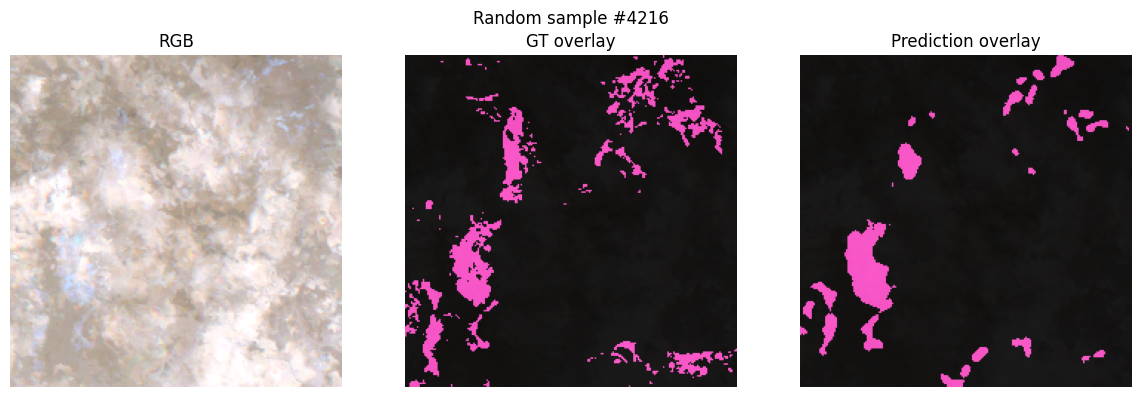

In [24]:

visualise_random_prediction(
    model,
    dataset=train_dataset,
    device=device,
    colour_encoding=DEFAULT_ENCODING,  # or your own
    rgb_divisor=3000.0,
    alpha=0.9
)


Now, try running the cell to mount Google Drive again.